In [225]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import csv
import numpy as np
import math

In [3]:
# Constants
MAX = 2e9
MIN = 1e-5
NUM_DEC = 5
FACTOR = 0.9
MIN_P = 0.55
MAX_P = 0.95
SMALL = 50
MEDIUM = 100
LARGE = 200

# same as number of TA's? TODO:fix this
SMALL_H = 50
MEDIUM_H = 100
LARGE_H = 200

# maximum number of TA's / homes
SMALL_TA = 25
MEDIUM_TA = 50
LARGE_TA = 100

In [4]:
# G = nx.Graph([(1,1), (2,2), (1,2), (1,2)])
G = nx.Graph()
G.add_node(1)
G.add_node(2)
G.add_edge(1, 2)
G.add_edge(2, 2)
A = nx.adjacency_matrix(G)
print(A.todense())

[[0 1]
 [1 1]]


In [8]:
G = nx.Graph()
# H = nx.path_graph(2)
# G.add_nodes_from(H)
G = nx.petersen_graph()
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw(G, pos=pos)
# plt.show()
# plt.subplot(121)

# nx.draw(G, with_labels=True, font_weight='bold')
# plt.subplot(122)

# nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')


ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')

[0, 1, 2]
[(0, 1), (0, 2), (1, 2)]
{'weight': 4.7}
9


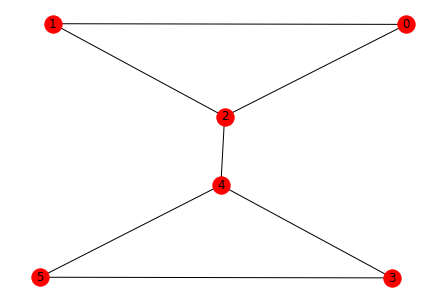

In [11]:
G1 = nx.complete_graph(3)
# plt.subplot(121)
# nx.draw(G1, node_color='blue', with_labels=True)
print(list(G1.nodes()))
print(list(G1.edges()))

G2 = nx.complete_graph(range(3,6))
# plt.subplot(122)
# nx.draw(G2, node_color='red', with_labels=True)

G3 = nx.union(G1, G2)
G3.add_edge(2, 4, weight=4.7)
print(G3[4][2])
nx.draw(G3, node_color='red', with_labels=True)
print(list(G.nodes()).pop())

In [113]:
def add_weights(g):
    w1 = rd.uniform(MIN, MAX)
    w2 = rd.uniform(MIN_P * w1, MAX_P * w1)
    w3 = rd.uniform(MIN_P * w1, MAX_P * w1)
    ws = [w1, w2, w3]
    for _, data in g.edges.items():
        data['weight'] = round(ws.pop(), NUM_DEC)
    
def connect(G, g):
    Gnodes = list(G.nodes)
    gnodes = list(g.nodes)
    G = nx.union(G, g)
    for n in gnodes:
        idx = rd.randrange(0, len(Gnodes))
        a = Gnodes.pop(idx)
        try:
            w = nx.shortest_path_length(G, source=a, target=n) * FACTOR
        except nx.NetworkXNoPath:
            ws = [i for _, _, i in g.edges.data('weight')]
            w = rd.uniform(min(ws), max(ws)) * FACTOR
        G.add_edge(a, n, weight=round(w, NUM_DEC))
    return G
        
def gen_graph(n):
    G = nx.Graph()
    while n:
        a = n.pop()
        b = n.pop()
        c = n.pop()
        nodes = [a, b, c]
        g = nx.complete_graph(nodes)
        add_weights(g)
        if len(G.nodes) == 0:
            G = g
        else:
            G = connect(G, g)
    return G

[[3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 1244979704.36479, 1922090307.76993, 'x'], [3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 1244979704.36479, 1922090307.76993, 'x'], [3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 1244979704.36479, 1922090307.76993, 'x'], [3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 1244979704.36479, 1922090307.76993, 'x'], [3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 1244979704.36479, 1922090307.76993, 'x'], [3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 1244979704.36479, 1922090307.76993, 'x'], [3.6, 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 12449

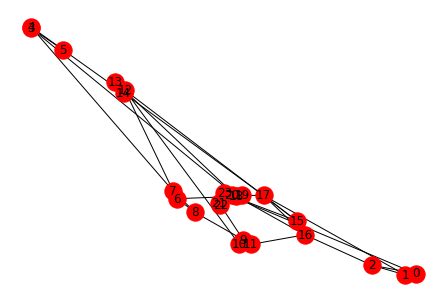

In [135]:
G = gen_graph(list(range(24)))
try:
    nx.shortest_path_length(G, source=2, target=3)
except nx.NetworkXNoPath:
    print("No path")
# for e in G.edges.items():
#     print(e)
nx.draw(G, node_color='red', with_labels=True)
A = nx.adjacency_matrix(G).toarray()
B = [[None] * len(A[0])] * len(A)
for i in range(len(A)):
    for j in range(len(A[0])):
        if A[i][j] == 0.0:
            B[i][j] = 'x'
        else:
            B[i][j] = A[i][j]
print(B)

In [136]:
def write_to_file(file, string, append=False):
    if append:
        mode = 'a'
    else:
        mode = 'w'
    with open(file, mode) as f:
        f.write(string)


def write_data_to_file(file, data, separator, append=False):
    if append:
        mode = 'a'
    else:
        mode = 'w'
    with open(file, mode) as f:
        for item in data:
            f.write(f'{item}{separator}')

In [145]:
f = open('world-cities.csv')
csv_f = csv.reader(f)
world_cities = []
for r in csv_f:
    name = r[0]
    if name.isalpha() and name != 'name':
        world_cities.append(name)
city_num = len(world_cities)
# print(world_cities)
small_list = []
medium_list = []
large_list = []
for i in range(SMALL):
    idx = rd.randrange(0, city_num)
    small_list.append(world_cities[idx])
for i in range(MEDIUM):
    idx = rd.randrange(0, city_num)
    medium_list.append(world_cities[idx])
for i in range(LARGE):
    idx = rd.randrange(0, city_num)
    large_list.append(world_cities[idx])

In [146]:
input_file = "7\n4\nSoda"
write_to_file("input.txt", input_file)

# Method 2: Complete Graph with Random Weights Adjusted

Generate a complete graph with random weights associated each edge. Use floyd_warshall to produce the 
all-pairs shortest path distances. For each edge, set the length of the edge to be the length of the shortest distance between those two vertices.

Drawbacks: After adjusting the weights, some points become lying along the way between two points as their middle points. It also requires more time to generate a valid graph.

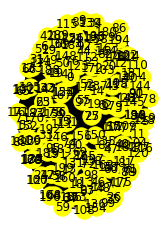

In [181]:
# Generate 
G_final = nx.complete_graph(LARGE)
plt.subplot(121)
nx.draw(G_final, node_color='yellow', with_labels=True)

# print(list(G1.nodes()))
# print(list(G1.edges()))

In [182]:
def print_edge_weights(g):
    for edge, data in g.edges.items():
        print(edge, data)  

In [194]:
def add_weights2(g, lower, upper):
    """Update the weight of each edge to be a random weight within the bounds."""
    for edge, data in g.edges.items():
        w = rd.uniform(lower, upper)
        data['weight'] = round(w, NUM_DEC)
#         print(edge, data)        

In [184]:
dict1 = nx.floyd_warshall(G_final, weight='weight')
# plt.subplot(121)
# nx.draw(G_final, node_color='yellow', with_labels=True)
# print(list(G_final.nodes()))
# print(list(G_final.edges().items()))
# dict1 = nx.all_pairs_shortest_path_length(G_final)

In [185]:
def print_shortest_pair_distance(g):
    rs = nx.floyd_warshall(g)
    for i in rs:
        for j in rs[i]:
            print ("%d\t%d\t%f" % (i, j, rs[i][j]))

In [190]:
def fix_triangle_inequalities(g):
    done = False
    count = 0
    num_fixes = 0
    while not done:
        done = True
        rs = nx.floyd_warshall(g, weight='weight')
        print("iteration ", count)
        for edge, data in g.edges.items():
            if data['weight'] > rs[edge[0]][edge[1]]:
#                 print('change ' + str(edge) + " " + str(data['weight']) + " to " + str(rs[edge[0]][edge[1]]))
                data['weight'] = rs[edge[0]][edge[1]]
                done = False
                num_fixes += 1
#                 break # with break will lead to less fixes but takes more time to update
        count += 1
    print("total fixes: ", num_fixes)

Generate random weight for each edge.

In [196]:
# G_final[2][3]['weight'] = 78.73409
add_weights2(G_final, MIN, MAX)
print_edge_weights(G_final)  

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class '

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class '

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class '

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class '

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class '

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class '

(1, 156) {'weight': 726511783.87918}
(1, 157) {'weight': 1769141572.28359}
(1, 158) {'weight': 666171011.60564}
(1, 159) {'weight': 1955010840.23116}
(1, 160) {'weight': 1715237002.5609}
(1, 161) {'weight': 569165903.35171}
(1, 162) {'weight': 654150568.20784}
(1, 163) {'weight': 1334626665.74135}
(1, 164) {'weight': 732779818.75938}
(1, 165) {'weight': 397141418.89437}
(1, 166) {'weight': 1114217203.35761}
(1, 167) {'weight': 105480972.20303}
(1, 168) {'weight': 206299997.82924}
(1, 169) {'weight': 1048218319.2039}
(1, 170) {'weight': 289787472.73147}
(1, 171) {'weight': 1141929495.21811}
(1, 172) {'weight': 242946528.93873}
(1, 173) {'weight': 1957125378.45891}
(1, 174) {'weight': 229280531.57611}
(1, 175) {'weight': 1346545506.13484}
(1, 176) {'weight': 1531359427.21616}
(1, 177) {'weight': 1982047650.45027}
(1, 178) {'weight': 1317224312.94896}
(1, 179) {'weight': 1924848377.81937}
(1, 180) {'weight': 1334253766.23007}
(1, 181) {'weight': 328931523.48047}
(1, 182) {'weight': 136175

(10, 112) {'weight': 775542926.69649}
(10, 113) {'weight': 1147320706.2833}
(10, 114) {'weight': 927375447.90589}
(10, 115) {'weight': 1184924158.95814}
(10, 116) {'weight': 898997182.3092}
(10, 117) {'weight': 597163575.11023}
(10, 118) {'weight': 1452368359.99566}
(10, 119) {'weight': 660243920.46603}
(10, 120) {'weight': 140393195.51441}
(10, 121) {'weight': 1464551435.63757}
(10, 122) {'weight': 1428976869.57329}
(10, 123) {'weight': 949183322.69914}
(10, 124) {'weight': 991384251.21741}
(10, 125) {'weight': 1180373242.52203}
(10, 126) {'weight': 285125903.30395}
(10, 127) {'weight': 1745067502.74233}
(10, 128) {'weight': 389660430.95665}
(10, 129) {'weight': 1168309864.38769}
(10, 130) {'weight': 131630454.82287}
(10, 131) {'weight': 652800035.90462}
(10, 132) {'weight': 335129198.41927}
(10, 133) {'weight': 946772221.02096}
(10, 134) {'weight': 481262516.99914}
(10, 135) {'weight': 618778687.06198}
(10, 136) {'weight': 1589730427.75955}
(10, 137) {'weight': 169508991.47401}
(10, 

(19, 196) {'weight': 132466147.36001}
(19, 197) {'weight': 1604848141.40434}
(19, 198) {'weight': 1895242100.5049}
(19, 199) {'weight': 1885677982.27299}
(20, 21) {'weight': 1538168739.51424}
(20, 22) {'weight': 215487971.51158}
(20, 23) {'weight': 1381728418.87732}
(20, 24) {'weight': 1847716909.99439}
(20, 25) {'weight': 1822093662.70473}
(20, 26) {'weight': 463734324.11083}
(20, 27) {'weight': 387134329.30904}
(20, 28) {'weight': 1537335080.72991}
(20, 29) {'weight': 984908339.74247}
(20, 30) {'weight': 1843134694.38295}
(20, 31) {'weight': 70434007.91236}
(20, 32) {'weight': 1152821567.53331}
(20, 33) {'weight': 503521136.52478}
(20, 34) {'weight': 1118579794.3226}
(20, 35) {'weight': 173870696.97247}
(20, 36) {'weight': 1345066727.30311}
(20, 37) {'weight': 1334562735.44742}
(20, 38) {'weight': 1843990039.00122}
(20, 39) {'weight': 113893236.83413}
(20, 40) {'weight': 438824359.05683}
(20, 41) {'weight': 1760649792.59146}
(20, 42) {'weight': 249646888.04655}
(20, 43) {'weight': 95

(29, 119) {'weight': 886521292.61661}
(29, 120) {'weight': 1843224299.33681}
(29, 121) {'weight': 633696201.67267}
(29, 122) {'weight': 459511420.01801}
(29, 123) {'weight': 931425014.17059}
(29, 124) {'weight': 1124000326.25869}
(29, 125) {'weight': 1210174679.93407}
(29, 126) {'weight': 811222591.62892}
(29, 127) {'weight': 1275576417.31893}
(29, 128) {'weight': 733027273.61227}
(29, 129) {'weight': 982279316.98685}
(29, 130) {'weight': 873505597.08352}
(29, 131) {'weight': 805678246.8608}
(29, 132) {'weight': 339568349.90302}
(29, 133) {'weight': 901098546.79724}
(29, 134) {'weight': 1906289101.3859}
(29, 135) {'weight': 1445591360.33509}
(29, 136) {'weight': 833034104.71645}
(29, 137) {'weight': 1635681192.563}
(29, 138) {'weight': 1754601688.90911}
(29, 139) {'weight': 710073679.79565}
(29, 140) {'weight': 1019003339.16893}
(29, 141) {'weight': 1341385576.38506}
(29, 142) {'weight': 1678779628.43122}
(29, 143) {'weight': 483832229.61045}
(29, 144) {'weight': 644860415.05896}
(29, 

(39, 150) {'weight': 1028815320.39949}
(39, 151) {'weight': 1441424171.66854}
(39, 152) {'weight': 1826819749.06932}
(39, 153) {'weight': 1086990520.77088}
(39, 154) {'weight': 1931031858.26275}
(39, 155) {'weight': 1016558493.5503}
(39, 156) {'weight': 380337784.07525}
(39, 157) {'weight': 1370245369.23325}
(39, 158) {'weight': 1730772328.47782}
(39, 159) {'weight': 1353394212.48905}
(39, 160) {'weight': 101068200.11954}
(39, 161) {'weight': 1352436381.51638}
(39, 162) {'weight': 1653692776.40281}
(39, 163) {'weight': 701188429.1959}
(39, 164) {'weight': 793776386.64597}
(39, 165) {'weight': 494164235.78154}
(39, 166) {'weight': 279936419.1937}
(39, 167) {'weight': 463354491.90519}
(39, 168) {'weight': 1806222506.65983}
(39, 169) {'weight': 320462757.37558}
(39, 170) {'weight': 1371256140.72401}
(39, 171) {'weight': 1048557800.03517}
(39, 172) {'weight': 1196921648.07572}
(39, 173) {'weight': 1821984049.45465}
(39, 174) {'weight': 1860960417.29716}
(39, 175) {'weight': 1569691618.1144

(51, 63) {'weight': 957560518.72062}
(51, 64) {'weight': 435513080.42123}
(51, 65) {'weight': 1083059681.93337}
(51, 66) {'weight': 783094537.53172}
(51, 67) {'weight': 411754349.54449}
(51, 68) {'weight': 1104563248.62876}
(51, 69) {'weight': 1319543196.19968}
(51, 70) {'weight': 1073991548.92963}
(51, 71) {'weight': 1159725302.98382}
(51, 72) {'weight': 1400264291.73198}
(51, 73) {'weight': 1650381824.35255}
(51, 74) {'weight': 1859443827.1962}
(51, 75) {'weight': 1700036494.16395}
(51, 76) {'weight': 423495380.3387}
(51, 77) {'weight': 1130481051.29707}
(51, 78) {'weight': 1832241415.71591}
(51, 79) {'weight': 1552212618.9462}
(51, 80) {'weight': 759426731.82027}
(51, 81) {'weight': 489810301.56422}
(51, 82) {'weight': 1236679804.75144}
(51, 83) {'weight': 837377032.24614}
(51, 84) {'weight': 838832562.98361}
(51, 85) {'weight': 615825406.27193}
(51, 86) {'weight': 1176914152.25782}
(51, 87) {'weight': 1674260837.25514}
(51, 88) {'weight': 233367353.89823}
(51, 89) {'weight': 192681

(63, 111) {'weight': 1155972398.76781}
(63, 112) {'weight': 615384843.00017}
(63, 113) {'weight': 390999888.0616}
(63, 114) {'weight': 1688261129.05049}
(63, 115) {'weight': 568824977.2484}
(63, 116) {'weight': 1249675263.17186}
(63, 117) {'weight': 251791309.39174}
(63, 118) {'weight': 186667267.91278}
(63, 119) {'weight': 1661288588.0492}
(63, 120) {'weight': 660787600.72727}
(63, 121) {'weight': 1192545595.90626}
(63, 122) {'weight': 1881259007.70429}
(63, 123) {'weight': 1221332353.34832}
(63, 124) {'weight': 1541261401.13409}
(63, 125) {'weight': 1135714029.16256}
(63, 126) {'weight': 1105490729.81962}
(63, 127) {'weight': 846316005.70115}
(63, 128) {'weight': 1598990060.81072}
(63, 129) {'weight': 285948654.2921}
(63, 130) {'weight': 1666762531.16891}
(63, 131) {'weight': 1223915455.70038}
(63, 132) {'weight': 907523150.24208}
(63, 133) {'weight': 575133575.29227}
(63, 134) {'weight': 1151355462.14387}
(63, 135) {'weight': 266459338.91924}
(63, 136) {'weight': 708171408.54448}
(6

(73, 169) {'weight': 1210154030.1477}
(73, 170) {'weight': 446384795.03363}
(73, 171) {'weight': 318824328.91285}
(73, 172) {'weight': 1246218652.46727}
(73, 173) {'weight': 519128749.41328}
(73, 174) {'weight': 8147302.95686}
(73, 175) {'weight': 1774689302.47073}
(73, 176) {'weight': 1717245398.32634}
(73, 177) {'weight': 1423182992.48362}
(73, 178) {'weight': 1542352239.01564}
(73, 179) {'weight': 786006436.52281}
(73, 180) {'weight': 1724341772.22697}
(73, 181) {'weight': 345790723.18727}
(73, 182) {'weight': 1089182976.1102}
(73, 183) {'weight': 229687072.20843}
(73, 184) {'weight': 997705942.08971}
(73, 185) {'weight': 458848100.88868}
(73, 186) {'weight': 1157840474.97574}
(73, 187) {'weight': 1743132644.05543}
(73, 188) {'weight': 1775079899.15041}
(73, 189) {'weight': 1746392698.31033}
(73, 190) {'weight': 1837091289.18749}
(73, 191) {'weight': 445772667.97598}
(73, 192) {'weight': 1868177946.10923}
(73, 193) {'weight': 1592963108.10553}
(73, 194) {'weight': 1802767310.06287}


(87, 122) {'weight': 782126407.2833}
(87, 123) {'weight': 970209432.72039}
(87, 124) {'weight': 858307453.24755}
(87, 125) {'weight': 25590262.13903}
(87, 126) {'weight': 758200348.0681}
(87, 127) {'weight': 1054596429.92757}
(87, 128) {'weight': 465286816.26824}
(87, 129) {'weight': 1979328946.79935}
(87, 130) {'weight': 1254748124.20121}
(87, 131) {'weight': 184516817.63325}
(87, 132) {'weight': 1407296044.06724}
(87, 133) {'weight': 325308118.49038}
(87, 134) {'weight': 115201714.19954}
(87, 135) {'weight': 298926033.21043}
(87, 136) {'weight': 1201626058.11865}
(87, 137) {'weight': 1905227384.96813}
(87, 138) {'weight': 1754140973.81263}
(87, 139) {'weight': 1894880539.69128}
(87, 140) {'weight': 688822096.07769}
(87, 141) {'weight': 70999284.02596}
(87, 142) {'weight': 584636858.88387}
(87, 143) {'weight': 1108693195.78841}
(87, 144) {'weight': 1431396984.80864}
(87, 145) {'weight': 398144507.01316}
(87, 146) {'weight': 364625164.98665}
(87, 147) {'weight': 1233044597.9767}
(87, 1

(102, 134) {'weight': 1749045038.2072}
(102, 135) {'weight': 495272539.10077}
(102, 136) {'weight': 689205931.9456}
(102, 137) {'weight': 306009256.87552}
(102, 138) {'weight': 1005491544.85652}
(102, 139) {'weight': 1654143584.96976}
(102, 140) {'weight': 1432313595.26324}
(102, 141) {'weight': 1231603715.33711}
(102, 142) {'weight': 711004713.57651}
(102, 143) {'weight': 448954265.75239}
(102, 144) {'weight': 1179917717.56453}
(102, 145) {'weight': 1995311236.71082}
(102, 146) {'weight': 834708788.67275}
(102, 147) {'weight': 258002005.6651}
(102, 148) {'weight': 853707725.5022}
(102, 149) {'weight': 1005663650.1149}
(102, 150) {'weight': 1565302848.20341}
(102, 151) {'weight': 1501789584.85597}
(102, 152) {'weight': 1556219976.2157}
(102, 153) {'weight': 834087775.38106}
(102, 154) {'weight': 659749556.18611}
(102, 155) {'weight': 299666501.23424}
(102, 156) {'weight': 262506073.60985}
(102, 157) {'weight': 133569622.97696}
(102, 158) {'weight': 1637035432.73768}
(102, 159) {'weight

(122, 182) {'weight': 1314271222.60991}
(122, 183) {'weight': 1887047771.23271}
(122, 184) {'weight': 1718398834.60617}
(122, 185) {'weight': 243848319.26912}
(122, 186) {'weight': 242092674.62904}
(122, 187) {'weight': 83641249.22981}
(122, 188) {'weight': 339097221.95375}
(122, 189) {'weight': 738808471.10805}
(122, 190) {'weight': 1980636698.11441}
(122, 191) {'weight': 1457781602.90685}
(122, 192) {'weight': 231495773.122}
(122, 193) {'weight': 1984107002.23295}
(122, 194) {'weight': 243538094.42276}
(122, 195) {'weight': 1920892861.753}
(122, 196) {'weight': 1043633268.42729}
(122, 197) {'weight': 460851902.86435}
(122, 198) {'weight': 692499099.75827}
(122, 199) {'weight': 1423487660.88836}
(123, 124) {'weight': 1736685983.90715}
(123, 125) {'weight': 1461081836.93438}
(123, 126) {'weight': 848295709.30211}
(123, 127) {'weight': 118996984.67899}
(123, 128) {'weight': 57569408.05786}
(123, 129) {'weight': 1226094036.67235}
(123, 130) {'weight': 1470465756.99417}
(123, 131) {'weigh

(145, 154) {'weight': 282541484.45437}
(145, 155) {'weight': 1270679514.66401}
(145, 156) {'weight': 701333344.71501}
(145, 157) {'weight': 1510502156.18593}
(145, 158) {'weight': 7427402.28238}
(145, 159) {'weight': 724114831.53739}
(145, 160) {'weight': 453264960.75968}
(145, 161) {'weight': 1828011932.57495}
(145, 162) {'weight': 1285067571.23974}
(145, 163) {'weight': 1337735658.84768}
(145, 164) {'weight': 67988882.01967}
(145, 165) {'weight': 1428046349.23185}
(145, 166) {'weight': 1082621304.66307}
(145, 167) {'weight': 382486759.59679}
(145, 168) {'weight': 29434705.27235}
(145, 169) {'weight': 1829683138.66579}
(145, 170) {'weight': 833741466.77282}
(145, 171) {'weight': 1746247545.34587}
(145, 172) {'weight': 72424150.82185}
(145, 173) {'weight': 1221722690.60648}
(145, 174) {'weight': 1415517709.14241}
(145, 175) {'weight': 597222324.49241}
(145, 176) {'weight': 1787028555.49435}
(145, 177) {'weight': 38695433.79866}
(145, 178) {'weight': 1428680516.97517}
(145, 179) {'weigh

(193, 199) {'weight': 1212564966.26411}
(194, 195) {'weight': 1165065903.50342}
(194, 196) {'weight': 763437816.46032}
(194, 197) {'weight': 1166926728.60025}
(194, 198) {'weight': 1992902194.85935}
(194, 199) {'weight': 1400777552.9467}
(195, 196) {'weight': 1772141247.45456}
(195, 197) {'weight': 1014697405.8936}
(195, 198) {'weight': 150443940.6717}
(195, 199) {'weight': 944797805.56557}
(196, 197) {'weight': 1297209304.78978}
(196, 198) {'weight': 1282823980.61163}
(196, 199) {'weight': 882360081.67527}
(197, 198) {'weight': 878812734.54254}
(197, 199) {'weight': 517049927.97259}
(198, 199) {'weight': 907230997.73856}


Fix the weight to satisfy the trangle inequalities.

In [192]:
# g_copy = G_final.copy()
# fix_triangle_inequalities(G_final)
# print_edge_weights(G_final)

fix_triangle_inequalities(G_final)
print_edge_weights(G_final)  

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
total fixes:  26663
(0, 1) {'weight': 33423665.027639996}
(0, 2) {'weight': 51833954.745179996}
(0, 3) {'weight': 48162486.64525}
(0, 4) {'weight': 28896556.300909996}
(0, 5) {'weight': 44102984.64580999}
(0, 6) {'weight': 48925717.40887}
(0, 7) {'weight': 60537163.59798}
(0, 8) {'weight': 43513709.83682}
(0, 9) {'weight': 24580092.10662}
(0, 10) {'weight': 63162086.53610999}
(0, 11) {'weight': 39899135.112519994}
(0, 12) {'weight': 31376125.074099995}
(0, 13) {'weight': 23442668.58639}
(0, 14) {'weight': 59222124.4488}
(0, 15) {'weight': 36994670.42807}
(0, 16) {'weight': 54443398.569539994}
(0, 17) {'weight': 64850819.41309999}
(0, 18) {'weight': 46474913.43581}
(0, 19) {'weight': 32623227.996349998}
(0, 20) {'weight': 30544137.225989997}
(0, 21) {'weight': 32870758.693469997}
(0, 22) {'weight': 32764211.870389994}
(0, 23) {'weight': 27825209.34368}
(0, 24) {'weight': 28592973.58665}
(0, 25) {'weight': 7743

(8, 155) {'weight': 65878413.51029}
(8, 156) {'weight': 39733996.96256}
(8, 157) {'weight': 58134721.34617}
(8, 158) {'weight': 82211584.05904}
(8, 159) {'weight': 54299054.31228}
(8, 160) {'weight': 68457709.42887999}
(8, 161) {'weight': 55400022.19015}
(8, 162) {'weight': 80486110.15821}
(8, 163) {'weight': 55612373.977390006}
(8, 164) {'weight': 56095217.09625}
(8, 165) {'weight': 62002592.047580004}
(8, 166) {'weight': 73984677.68431}
(8, 167) {'weight': 28455724.708979998}
(8, 168) {'weight': 42156620.02457}
(8, 169) {'weight': 59417500.376609996}
(8, 170) {'weight': 38490457.532979995}
(8, 171) {'weight': 51966747.85914}
(8, 172) {'weight': 55615881.53691}
(8, 173) {'weight': 36740161.3302}
(8, 174) {'weight': 53519682.06897999}
(8, 175) {'weight': 36403131.71007}
(8, 176) {'weight': 60366054.559879996}
(8, 177) {'weight': 52556036.57082}
(8, 178) {'weight': 50468300.5606}
(8, 179) {'weight': 48344553.20501}
(8, 180) {'weight': 55187618.37157}
(8, 181) {'weight': 45987136.1974699

(18, 69) {'weight': 63359443.38335}
(18, 70) {'weight': 49431510.69312}
(18, 71) {'weight': 56308156.73312999}
(18, 72) {'weight': 58918635.86186}
(18, 73) {'weight': 41520356.60876}
(18, 74) {'weight': 46179563.32881}
(18, 75) {'weight': 65833587.414419994}
(18, 76) {'weight': 26931809.8967}
(18, 77) {'weight': 58853265.668349996}
(18, 78) {'weight': 43076295.51062}
(18, 79) {'weight': 57463368.76104}
(18, 80) {'weight': 74317189.98802999}
(18, 81) {'weight': 48990705.649239995}
(18, 82) {'weight': 68841596.66161999}
(18, 83) {'weight': 44476976.16941}
(18, 84) {'weight': 62429037.71053}
(18, 85) {'weight': 103514279.27543}
(18, 86) {'weight': 7997513.30382}
(18, 87) {'weight': 80530960.79784}
(18, 88) {'weight': 72011032.85522999}
(18, 89) {'weight': 61879652.64557999}
(18, 90) {'weight': 64351126.36231999}
(18, 91) {'weight': 49922687.56862}
(18, 92) {'weight': 31643877.30872}
(18, 93) {'weight': 27298415.06959}
(18, 94) {'weight': 47222097.45982}
(18, 95) {'weight': 56244103.98109}

(28, 60) {'weight': 45740617.61871}
(28, 61) {'weight': 81591769.57930999}
(28, 62) {'weight': 89421614.03007999}
(28, 63) {'weight': 38395701.23512}
(28, 64) {'weight': 86268621.10584}
(28, 65) {'weight': 79247476.02562}
(28, 66) {'weight': 58194599.70601}
(28, 67) {'weight': 88497095.16669999}
(28, 68) {'weight': 76179854.98304999}
(28, 69) {'weight': 64253458.461459994}
(28, 70) {'weight': 76479099.97533}
(28, 71) {'weight': 79479326.47272}
(28, 72) {'weight': 80308292.06737}
(28, 73) {'weight': 62910012.81427}
(28, 74) {'weight': 69350733.0684}
(28, 75) {'weight': 47694760.93474}
(28, 76) {'weight': 82417439.96686}
(28, 77) {'weight': 52604189.65574}
(28, 78) {'weight': 54988898.82671001}
(28, 79) {'weight': 78853024.96655}
(28, 80) {'weight': 33968393.33588}
(28, 81) {'weight': 70263084.52604}
(28, 82) {'weight': 98629908.03465}
(28, 83) {'weight': 67648145.909}
(28, 84) {'weight': 58973540.41}
(28, 85) {'weight': 87504056.64736}
(28, 86) {'weight': 82438172.66240999}
(28, 87) {'w

(38, 148) {'weight': 52467838.56808999}
(38, 149) {'weight': 12480290.75979}
(38, 150) {'weight': 58222477.03443}
(38, 151) {'weight': 40088225.22144}
(38, 152) {'weight': 59102182.22969999}
(38, 153) {'weight': 39420323.4919}
(38, 154) {'weight': 73735488.59833}
(38, 155) {'weight': 65065128.155839995}
(38, 156) {'weight': 39084840.24115999}
(38, 157) {'weight': 56633079.98775}
(38, 158) {'weight': 24124184.91157}
(38, 159) {'weight': 31470343.52343}
(38, 160) {'weight': 82623145.21934}
(38, 161) {'weight': 60527377.35136}
(38, 162) {'weight': 57336318.79401999}
(38, 163) {'weight': 58008175.377859995}
(38, 164) {'weight': 35631894.590330005}
(38, 165) {'weight': 49431974.5888}
(38, 166) {'weight': 51155966.89546}
(38, 167) {'weight': 42621160.49944}
(38, 168) {'weight': 35426732.29476}
(38, 169) {'weight': 3818829.94162}
(38, 170) {'weight': 50595003.28762999}
(38, 171) {'weight': 27700960.53677}
(38, 172) {'weight': 26213863.510640003}
(38, 173) {'weight': 36091004.608799994}
(38, 1

(49, 182) {'weight': 57857489.96591}
(49, 183) {'weight': 74575469.29744999}
(49, 184) {'weight': 85016380.09936}
(49, 185) {'weight': 97448794.18891999}
(49, 186) {'weight': 69571881.66415}
(49, 187) {'weight': 60662273.31130999}
(49, 188) {'weight': 77107144.70554}
(49, 189) {'weight': 64835932.02273}
(49, 190) {'weight': 26606539.665090002}
(49, 191) {'weight': 58390191.08833}
(49, 192) {'weight': 47665263.41071}
(49, 193) {'weight': 68166317.37479}
(49, 194) {'weight': 62279290.10499}
(49, 195) {'weight': 55051937.56068}
(49, 196) {'weight': 86533673.80669999}
(49, 197) {'weight': 55940654.092250004}
(49, 198) {'weight': 59864547.06662999}
(49, 199) {'weight': 112857636.42923999}
(50, 51) {'weight': 50397374.79953}
(50, 52) {'weight': 42315593.55456999}
(50, 53) {'weight': 49250236.09894}
(50, 54) {'weight': 43722665.0411}
(50, 55) {'weight': 132862236.59311998}
(50, 56) {'weight': 12718184.7205}
(50, 57) {'weight': 61922499.732779995}
(50, 58) {'weight': 45467074.17379}
(50, 59) {

(62, 86) {'weight': 60034444.52075}
(62, 87) {'weight': 91566948.91352999}
(62, 88) {'weight': 67662165.02747}
(62, 89) {'weight': 62494901.97105999}
(62, 90) {'weight': 75387114.47801}
(62, 91) {'weight': 60958675.68431}
(62, 92) {'weight': 90625958.62524998}
(62, 93) {'weight': 86280496.38611999}
(62, 94) {'weight': 52068420.56339999}
(62, 95) {'weight': 62403997.22670999}
(62, 96) {'weight': 95170874.62879999}
(62, 97) {'weight': 81894591.98581}
(62, 98) {'weight': 27945572.3889}
(62, 99) {'weight': 43403348.56082}
(62, 100) {'weight': 96849530.18858999}
(62, 101) {'weight': 84068959.93353}
(62, 102) {'weight': 100936999.74297999}
(62, 103) {'weight': 72699478.27276999}
(62, 104) {'weight': 41472566.48231}
(62, 105) {'weight': 55679305.10716999}
(62, 106) {'weight': 78357681.35455}
(62, 107) {'weight': 53295994.816089995}
(62, 108) {'weight': 73155367.74996999}
(62, 109) {'weight': 67280258.45019001}
(62, 110) {'weight': 71791041.09071}
(62, 111) {'weight': 79328584.9533}
(62, 112) 

(75, 115) {'weight': 52266117.892069995}
(75, 116) {'weight': 62610815.37916}
(75, 117) {'weight': 69696870.4118}
(75, 118) {'weight': 68082547.58153999}
(75, 119) {'weight': 57339244.594419986}
(75, 120) {'weight': 54227455.40481}
(75, 121) {'weight': 73993755.80844}
(75, 122) {'weight': 37254148.03593}
(75, 123) {'weight': 64076023.62084999}
(75, 124) {'weight': 39764384.66338}
(75, 125) {'weight': 26595976.82288}
(75, 126) {'weight': 62795229.57674}
(75, 127) {'weight': 35317261.10477}
(75, 128) {'weight': 41040923.47452}
(75, 129) {'weight': 17835932.39075}
(75, 130) {'weight': 56332708.25756999}
(75, 131) {'weight': 35730145.98145}
(75, 132) {'weight': 49683522.83855}
(75, 133) {'weight': 56400667.142289996}
(75, 134) {'weight': 37335602.55998}
(75, 135) {'weight': 63568773.55525}
(75, 136) {'weight': 69190601.88641}
(75, 137) {'weight': 57069501.382939994}
(75, 138) {'weight': 57146773.835839994}
(75, 139) {'weight': 57216939.464719996}
(75, 140) {'weight': 49887004.661189996}
(7

(90, 126) {'weight': 61643774.35040999}
(90, 127) {'weight': 65911470.191049986}
(90, 128) {'weight': 45363149.196909994}
(90, 129) {'weight': 49237710.78465}
(90, 130) {'weight': 76288107.16564}
(90, 131) {'weight': 66324355.067729995}
(90, 132) {'weight': 66182680.78682999}
(90, 133) {'weight': 79453612.52564}
(90, 134) {'weight': 35853141.50788}
(90, 135) {'weight': 41881544.2866}
(90, 136) {'weight': 75629208.45931}
(90, 137) {'weight': 62686745.54278}
(90, 138) {'weight': 42061203.70636}
(90, 139) {'weight': 78422522.21431999}
(90, 140) {'weight': 64932512.01764999}
(90, 141) {'weight': 49768578.97433999}
(90, 142) {'weight': 59584048.35998}
(90, 143) {'weight': 54726267.49265999}
(90, 144) {'weight': 82306105.70628}
(90, 145) {'weight': 73540916.6505}
(90, 146) {'weight': 95484779.26938999}
(90, 147) {'weight': 71492135.51539}
(90, 148) {'weight': 87895804.57107}
(90, 149) {'weight': 69698335.24231}
(90, 150) {'weight': 102304392.95944998}
(90, 151) {'weight': 73481561.1818}
(90,

(107, 193) {'weight': 67342130.36290999}
(107, 194) {'weight': 63565666.751239985}
(107, 195) {'weight': 30981544.995319996}
(107, 196) {'weight': 54334014.61848}
(107, 197) {'weight': 53200727.91400999}
(107, 198) {'weight': 21170763.725649998}
(107, 199) {'weight': 83533211.21043}
(108, 109) {'weight': 37080503.59036}
(108, 110) {'weight': 63122241.99226999}
(108, 111) {'weight': 100402973.68152}
(108, 112) {'weight': 57375781.882769994}
(108, 113) {'weight': 46681006.91973}
(108, 114) {'weight': 78477869.00786}
(108, 115) {'weight': 76298797.49252999}
(108, 116) {'weight': 66377851.2883}
(108, 117) {'weight': 67428842.28263}
(108, 118) {'weight': 59507531.223299995}
(108, 119) {'weight': 49694734.53537}
(108, 120) {'weight': 31190970.99564}
(108, 121) {'weight': 67212784.28355}
(108, 122) {'weight': 48547978.29343}
(108, 123) {'weight': 69382814.61361}
(108, 124) {'weight': 56663655.263409995}
(108, 125) {'weight': 43577079.57154}
(108, 126) {'weight': 48812412.31262}
(108, 127) {'w

(129, 165) {'weight': 83238606.56489}
(129, 166) {'weight': 37509310.04626}
(129, 167) {'weight': 43734988.276429996}
(129, 168) {'weight': 60845602.48045}
(129, 169) {'weight': 64741108.79749}
(129, 170) {'weight': 63560294.49004}
(129, 171) {'weight': 55178540.08986}
(129, 172) {'weight': 63771383.757989995}
(129, 173) {'weight': 44895663.55128}
(129, 174) {'weight': 69922939.55512999}
(129, 175) {'weight': 45331568.69181}
(129, 176) {'weight': 75645318.12732999}
(129, 177) {'weight': 19634676.41459}
(129, 178) {'weight': 58775185.21412}
(129, 179) {'weight': 81983727.4167}
(129, 180) {'weight': 71354665.66339}
(129, 181) {'weight': 61266399.764919996}
(129, 182) {'weight': 83855280.74208999}
(129, 183) {'weight': 70232795.44121}
(129, 184) {'weight': 77817208.56485999}
(129, 185) {'weight': 48831191.50299}
(129, 186) {'weight': 53723781.11256}
(129, 187) {'weight': 60906348.649059996}
(129, 188) {'weight': 81554747.35514}
(129, 189) {'weight': 78801106.73019}
(129, 190) {'weight': 6

(160, 183) {'weight': 70102144.84874}
(160, 184) {'weight': 72607046.53807}
(160, 185) {'weight': 100389463.57533}
(160, 186) {'weight': 95042858.6239}
(160, 187) {'weight': 60388688.07259999}
(160, 188) {'weight': 79375597.24354}
(160, 189) {'weight': 93409987.52575001}
(160, 190) {'weight': 86798268.34466}
(160, 191) {'weight': 84129944.75738999}
(160, 192) {'weight': 76347468.91246998}
(160, 193) {'weight': 53702304.11891}
(160, 194) {'weight': 76610548.55419}
(160, 195) {'weight': 62495695.73835}
(160, 196) {'weight': 88869080.64756}
(160, 197) {'weight': 83336151.33269}
(160, 198) {'weight': 86960338.07744999}
(160, 199) {'weight': 122843328.29929}
(161, 162) {'weight': 71331152.31837}
(161, 163) {'weight': 31254681.4995}
(161, 164) {'weight': 70426030.18646}
(161, 165) {'weight': 76333600.41078}
(161, 166) {'weight': 74333633.54216999}
(161, 167) {'weight': 48419991.40227}
(161, 168) {'weight': 34204699.4765}
(161, 169) {'weight': 63938684.72962999}
(161, 170) {'weight': 32407858

# Method 3: Generate Random Coordinates Within Bounds

Genearte random points with coordinates (x, y), where 0< x < 1billion and 0 < y < 1 billion st the maximum possible weight is sqrt(1billion^2 + 1billion^2). They just calcuate the edge weight for each edge between vertices

In [236]:
def generate_random_coordinates(num_verticies, lower, upper):
    coords = []
    minX = float('inf')
    minY = float('inf')
    maxX = -float('inf')
    maxY = -float('inf')
    for i in range(num_verticies):
        x = round(rd.uniform(lower, upper), NUM_DEC)
        y = round(rd.uniform(lower, upper), NUM_DEC)
        coords.append((x, y))
        if x < minX:
            minX = x
        if y < minY:
            minY = y
        if x > maxX:
            maxX = x
        if y > maxY:
            maxY = y
    print("minX: ", minX)
    print("minY: ", minY)
    print("maxX: ", maxX)
    print("maxY: ", maxY)
#     print(coords)
    return coords

def calculate_dist(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

In [219]:
# Plot coordinates in scatter plot
def plot_coordinates(data):
    """data: list of tuples (x, y)"""
    data = np.array(data)
    x, y = data.T
    plt.scatter(x,y)
    plt.show()

minX:  24309760.6017
minY:  11020555.08537
maxX:  1999537462.9686
maxY:  1992630714.05749


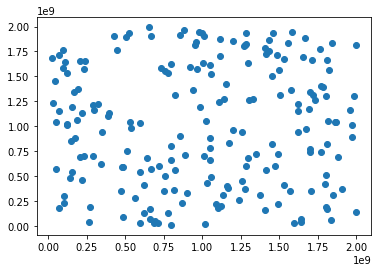

In [240]:
coords = generate_random_coordinates(200, MIN, MAX)
plot_coordinates(coords)

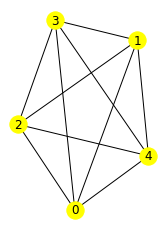

In [251]:
# Generate 
G_final = nx.complete_graph(5)
plt.subplot(121)
nx.draw(G_final, node_color='yellow', with_labels=True)

In [252]:
def add_weights3(g, coords):
    """Update the weight of each edge to be the distance between their location."""
    for edge, data in g.edges.items():
        data['weight'] = round(calculate_dist(coords[edge[0]], coords[edge[1]]), NUM_DEC)
        print(str(edge) + "weight: " + str(data['weight']))

In [253]:
add_weights3(G_final, coords)

(0, 1)weight: 1107649901.36838
(0, 2)weight: 1266359876.43579
(0, 3)weight: 1337251567.23533
(0, 4)weight: 1341188689.37368
(1, 2)weight: 1427122335.54169
(1, 3)weight: 1188559118.59983
(1, 4)weight: 1701902309.30008
(2, 3)weight: 375900774.72362
(2, 4)weight: 325159375.57494
(3, 4)weight: 698987670.89616


In [255]:
fix_triangle_inequalities(G_final)

iteration  0
total fixes:  0
